<font size=+4><b>TP CNN</b></font>

Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   


Polytech - SI4 - 2024-2025

In [2]:
import torch

import random
import numpy as np
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Dataset

In this lab we will use a subset of the well-know <a href="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/">Pascal VOC 2012</a> dataset. We have chosen the images that contain only one object from the 20 initial classes and selected the 3 most important classes: cat, dog and bird.
You can download <a href="https://unice-my.sharepoint.com/:u:/g/personal/diane_lingrand_unice_fr/EfF1QoAwABtIhmR2cJKtybABTFXKgCp3Gl-Yt7Z5wVG1oA?e=Tt7Ijl">here</a>, using your UniCA account, the reduced dataset and decompress the archive on your hard disk (or google drive if you are working on google colab). Note the where you decompress the archive and set the corresponding variable:

In [6]:
homedir = 'C:\\Users\\abbon\\OneDrive\\Documents\\SI4\\deep_leaning\\TP5\\CatDogBird\\'

Look at the files in the 'CatDogBird' directory. For each xml file, there is a corresponding jpg file. Inside the xml file, different informations are available. In this lab we will focus only on the class name.

In [8]:
classesNames=['cat','dog','bird']
nbClasses = len(classesNames)

listXml = glob.glob(homedir+'*.xml')
listImgFiles=[]
listLabels=[]

for xml in listXml:
    for d in ET.parse(xml).getroot().findall('.//object/name'):
        if d.text=='cat':
            listLabels.append(0)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='dog':
            listLabels.append(1)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='bird':
            listLabels.append(2)
            listImgFiles.append(xml[:-4]+'.jpg')

Let's have a look to a random image!

(-0.5, 249.5, 349.5, -0.5)

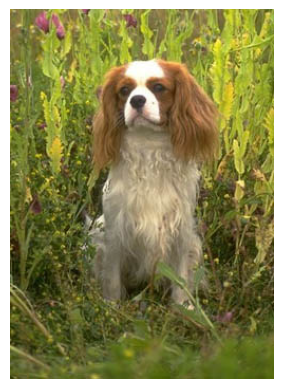

In [10]:
index = random.randint(0,len(listImgFiles))
img = plt.imread(listImgFiles[index])
plt.imshow(img)
plt.axis('off')

<font color="green"><b>Question:</b></font> How many samples are there in this dataset? How many samples per class? Do all images have the same dimensions? (you can answer the last question by running the previous cell multiple times)

In [12]:
total_samples = len(listImgFiles)

class_counts = {0: 0, 1: 0, 2: 0} 

for label in listLabels:
    class_counts[label] += 1

print(f'Total samples: {total_samples}')
print('\n\033[1mSamples per class:\033[0m')
for class_name, count in zip(classesNames, class_counts.values()):
    print(f'                 {class_name}: {count}')

Total samples: 2007

Samples per class:
                 cat: 745
                 dog: 694
                 bird: 568


In [13]:
image_shapes = []

for img_file in listImgFiles:
    img = plt.imread(img_file)
    image_shapes.append(img.shape)

# Convertir en numpy array pour faciliter les opérations
image_shapes = np.array(image_shapes)

# Vérifier si toutes les images ont la même dimension
same_dimensions = np.all(image_shapes == image_shapes[0])

# Afficher les résultats
if same_dimensions:
    print(f'All images have the same dimensions: {image_shapes[0]}')
else:
    print('Images have different dimensions.')

Images have different dimensions.


<font color="green"><b>Question:</b></font> Load the images as color images of type float32 and dimension 224 by 224 and perform the pre-processing for a VGG16 network. The resulting data tensor X should be of shape (nbOfSamples, 224, 224, 3). We give you a hint for a single filename:

Be also aware that it is more effective to allocate the memory needed at once than adding space for each image.

In [16]:
img_size = (224, 224)

X = np.zeros((total_samples, img_size[0], img_size[1], 3), dtype=np.float32)

for i, img_file in enumerate(listImgFiles):
    img = image.load_img(img_file, target_size=img_size)
    im = image.img_to_array(img)  # Convertir l'image en tableau
    im = np.expand_dims(im, axis=0)  # Ajouter une dimension pour le lot
    im = preprocess_input(im)  # Prétraitement pour VGG16
    X[i] = im[0]  # Stocker l'image prétraitée dans le tableau

# Afficher la forme finale de X
print(f'Shape of X: {X.shape}')

Shape of X: (2007, 224, 224, 3)


<font color='red'>For teachers, verify this question carefully and, if needed, give the correction of this cell to the student.</font>

<font color="green"><b>Question:</b></font> Split into train/test. Set a fixed seed so that you will be able to split the same way for another run. For example, if you want to modify the CNN, you will have to redo the pre-processing and build another X data. Convert the integer labels to categorical labels.

In [101]:
y = np.array(listLabels)
seed = 42
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

[[[ 74.061      42.221      -1.6800003]
  [ 72.061      43.221      -5.6800003]
  [ 79.061      46.221      -1.6800003]
  ...
  [ 66.061      42.221       5.3199997]
  [ 68.061      41.221      -1.6800003]
  [ 67.061      38.221      -4.6800003]]

 [[ 72.061      43.221       0.3199997]
  [ 70.061      41.221      -1.6800003]
  [ 69.061      37.221      -2.6800003]
  ...
  [ 65.061      35.221       1.3199997]
  [ 74.061      43.221      -0.6800003]
  [ 75.061      44.221       0.3199997]]

 [[ 58.060997   33.221      -7.6800003]
  [ 54.060997   23.221     -14.68     ]
  [ 55.060997   25.221      -8.68     ]
  ...
  [ 71.061      38.221       6.3199997]
  [ 79.061      45.221       7.3199997]
  [ 78.061      44.221       6.3199997]]

 ...

 [[-32.939003  -27.779     -27.68     ]
  [-31.939003  -25.779     -25.68     ]
  [-17.939003  -11.778999  -13.68     ]
  ...
  [-11.939003    4.2210007   1.3199997]
  [  5.060997   19.221       8.32     ]
  [ 28.060997   40.221      29.32     ]]

 [

<font color="green"><b>Question:</b></font> What are the shapes for xTrain and xTest? For train and test, how many samples per class? Are the classes balanced?

In [21]:
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

train_class_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("\nTraining samples per class:")
for i, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f'Class {i}: {count} samples')

test_class_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print("\nTesting samples per class:")
for i, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f'Class {i}: {count} samples')

min_train_count = min(train_class_counts[1])
max_train_count = max(train_class_counts[1])

min_test_count = min(test_class_counts[1])
max_test_count = max(test_class_counts[1])

print(f'\nTraining set is balanced: {min_train_count == max_train_count}')
print(f'Testing set is balanced: {min_test_count == max_test_count}')

Training data shape: (1605, 224, 224, 3), Training labels shape: (1605, 3)
Testing data shape: (402, 224, 224, 3), Testing labels shape: (402, 3)

Training samples per class:
Class 0: 605 samples
Class 1: 549 samples
Class 2: 451 samples

Testing samples per class:
Class 0: 140 samples
Class 1: 145 samples
Class 2: 117 samples

Training set is balanced: False
Testing set is balanced: False


<font color="green"><b>Question:</b></font> Compute the accuracy of 2 classifers:
<ul><li>classification always to the majority class</li>
<li>random classification (uniform law)</li></ul>

In [23]:
y_test_labels = np.argmax(y_test, axis=1)

# 1. Identify the majority class
unique, counts = np.unique(y_test_labels, return_counts=True)
majority_class = unique[np.argmax(counts)]
majority_class_count = counts[np.argmax(counts)]

# 2. Accuracy of the Majority Class Classifier
majority_class_predictions = np.full(y_test_labels.shape, majority_class)
majority_class_accuracy = np.sum(majority_class_predictions == y_test_labels) / len(y_test_labels)

print(f'Majority Class: {majority_class} (Count: {majority_class_count})')
print(f'Majority Classifier Accuracy: {majority_class_accuracy:.4f}')

# 3. Accuracy of the Random Classifier
num_classes = len(unique)
random_predictions = np.random.randint(0, num_classes, size=len(y_test_labels))
random_accuracy = np.sum(random_predictions == y_test_labels) / len(y_test_labels)

print(f'Random Classifier Accuracy: {random_accuracy:.4f}')

Majority Class: 1 (Count: 145)
Majority Classifier Accuracy: 0.3607
Random Classifier Accuracy: 0.3557


# Build your own CNN network

Start with the simplest CNN: 1 conv2D layer + 1 pooling + 1 dense layer.

In [26]:
model = Sequential()
model.add(Conv2D(4, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(nbClasses, activation='softmax'))

D:\Programmes\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<font color="green"><b>Question:</b></font> Let's look at the dimension of all inputs and outputs! How many parameters will you have to learn? In which part of the network are most of the parameters?

In [28]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,867 (12.26 MB)

 Trainable params: 3,213,867 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

<font color="green"><b>Question:</b></font> Learn and test this network. 

In [30]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.3543 - loss: 32.3821 - val_accuracy: 0.4206 - val_loss: 6.5289
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4225 - loss: 6.6850 - val_accuracy: 0.4548 - val_loss: 1.5098
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4462 - loss: 1.4321 - val_accuracy: 0.3988 - val_loss: 1.0958
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4585 - loss: 1.0175 - val_accuracy: 0.3863 - val_loss: 1.1161
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4853 - loss: 1.0255 - val_accuracy: 0.4237 - val_loss: 1.0868
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.4697 - loss: 1.0142 - val_accuracy: 0.4517 - val_loss: 1.0828
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.5153 - loss: 0.9634 - val_accuracy: 0.4642 - val_loss: 1.0629
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5214 - loss: 0.9247 - val_accuracy: 0

<font color="green"><b>Question:</b></font> Are you satisfied by the performances?
Try to modify the architecture (add layers) and some of the hyper-parameters. For some of the architectures, learning will be difficult. If you are stucked with the learning, try the next paragraphs about Dropout and Batch Normalisation.

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f} %')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4936 - loss: 1.0377
Test accuracy: 49.00 %


## About Dropout 

*Study this part only if you have time for it. It concerns the previous network but prefer to study first part II and come back here after.*

Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.

Why use dropout ? A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to overfitting of training data.

**Let's add dropout and activation functions to the network!**

In [35]:
# HERE IS AN EXAMPLE OF CODE, NOT A GOOD NETWORK FOR YOUR PROBLEM
from keras.layers import Dropout

model = Sequential(name='small CNN model with dropout') 

model = Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(200,activation='relu'))
# adding dropout to the previous layer
model.add(Dropout(0.2))

model.add(Dense(nbClasses, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,171 (231.14 KB)

 Trainable params: 59,171 (231.14 KB)

 Non-trainable params: 0 (0.00 B)

We suggest to add dropout layers before layers with many parameters to be learned.

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,171 (231.14 KB)

 Trainable params: 59,171 (231.14 KB)

 Non-trainable params: 0 (0.00 B)

## Batch normalisation

Implementation using keras <a href="https://keras.io/api/layers/normalization_layers/batch_normalization/">BatchNormalization</a> class.

In [40]:
model.add(BatchNormalization())

# Using a pre-learned network

## loading VGG-16 description part and adding layers to build our own classification network

In [43]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
VGGmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
#m = Dense(1024, activation='relu')(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)

<font color="green"><b>Question:</b></font>  Can you display the architecture of this entire network?

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 14,716,227 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
print(X_train[0])

[[[ 1.0563511e-15  6.0220903e-16 -2.3962276e-17]
  [ 1.0278245e-15  6.1647233e-16 -8.1015307e-17]
  [ 1.1276674e-15  6.5926205e-16 -2.3962276e-17]
  ...
  [ 9.4224517e-16  6.0220903e-16  7.5880527e-17]
  [ 9.7077154e-16  5.8794574e-16 -2.3962276e-17]
  [ 9.5650836e-16  5.4515602e-16 -6.6752046e-17]]

 [[ 1.0278245e-15  6.1647233e-16  4.5642383e-18]
  [ 9.9929813e-16  5.8794574e-16 -2.3962276e-17]
  [ 9.8503473e-16  5.3089278e-16 -3.8225535e-17]
  ...
  [ 9.2798187e-16  5.0236619e-16  1.8827498e-17]
  [ 1.0563511e-15  6.1647233e-16 -9.6990194e-18]
  [ 1.0706144e-15  6.3073551e-16  4.5642383e-18]]

 [[ 8.2813903e-16  4.7383976e-16 -1.0954182e-16]
  [ 7.7108591e-16  3.3120711e-16 -2.0938463e-16]
  [ 7.8534926e-16  3.5973365e-16 -1.2380509e-16]
  ...
  [ 1.0135613e-15  5.4515602e-16  9.0143781e-17]
  [ 1.1276674e-15  6.4499881e-16  1.0440705e-16]
  [ 1.1134041e-15  6.3073551e-16  9.0143781e-17]]

 ...

 [[-4.6981752e-16 -3.9621901e-16 -3.9480698e-16]
  [-4.5555433e-16 -3.6769250e-16 -3.662

<font color="green"><b>Question:</b></font> Train and evaluate this network

In [76]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

for layer in VGGmodel.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=32,  
    validation_data=(X_test, y_test)
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.3833 - loss: 1.0897 - val_accuracy: 0.3483 - val_loss: 1.0961
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3894 - loss: 1.0898 - val_accuracy: 0.3483 - val_loss: 1.0959
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3776 - loss: 1.0925 - val_accuracy: 0.3483 - val_loss: 1.0962
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3752 - loss: 1.0946 - val_accuracy: 0.3483 - val_loss: 1.0958
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3775 - loss: 1.0935 - val_accuracy: 0.3483 - val_loss: 1.0957
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3730 - loss: 1.0938 - val_accuracy: 0.3483 - val_loss: 1.0970
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3649 - loss: 1.0969 - val_accuracy: 0.3483 - val_loss: 1.0966
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.3654 - loss: 1.0925 - val_accuracy: 0.3483 - val_l

In [97]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

 3/13 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2465 - loss: 1.1268

KeyboardInterrupt: 

<font color="green"><b>Question:</b></font> When your network is working, find the index of wrongly classified images and display them.

13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ -7379.446    3626.3552  -3488.4001]
  [ -6869.446    4136.355   -2978.4001]
  [ -7634.446    3371.3552  -3743.4001]
  ...
  [-19874.445   13316.355    4671.6   ]
  [-19619.445   13571.355    4926.6   ]
  [-20639.445   12806.355    3651.5999]]

 [[ -6869.446    3371.3552  -3488.4001]
  [ -6614.446    3626.3552  -3233.4001]
  [ -6614.446    3626.3552  -3233.4001]
  ...
  [-20129.445   13061.355    4416.6   ]
  [-20129.445   13061.355    4416.6   ]
  [-19874.445   13316.355    4671.6   ]]

 [[ -5849.446    3371.3552  -3488.4001]
  [ -6104.446    3626.3552  -3233.4001]
  [ -6614.446    3116.3552  -3743.4001]
  ...
  [-20384.445   12806.355    4161.6   ]
  [-20129.445   13061.355    4926.6   ]
  [-21149.445   11786.355    4161.6   ]]

 ...

 [[-18089.445  -13713.645  -12668.4   ]
  [-19619.445  -15753.645  -14708.4   ]
  [-20384.445  -16518.645  -15473.4   ]
  ...
  [-10694.445   -8613.645   -8333.4   ]
  [-10694.445   -9123.645   -7568.4   ]
  [-10694.445   -9123.645   -7568.4   ]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-15539.445   -18048.645   -18788.4    ]
  [-17324.445   -19323.645   -18788.4    ]
  [-15794.445   -17538.645   -15983.4    ]
  ...
  [ -1514.4458    3371.3552   10791.6    ]
  [-21914.445   -20598.645   -14963.4    ]
  [-23954.445   -20343.645   -13433.4    ]]

 [[-17324.445   -18048.645   -18023.4    ]
  [-17579.445   -17283.645   -15983.4    ]
  [-16814.445   -16263.645   -13943.4    ]
  ...
  [-25484.445   -15753.645    -7313.4    ]
  [-17834.445   -11418.645    -4253.4    ]
  [-21659.445   -20343.645   -17768.4    ]]

 [[-17834.445   -18813.645   -17258.4    ]
  [-15284.445   -14478.645   -11903.4    ]
  [-16304.445   -14733.645   -11138.4    ]
  ...
  [-19874.445   -10653.645    -4253.4    ]
  [-24719.445   -17793.645   -12158.4    ]
  [-21149.445   -19068.645   -17003.4    ]]

 ...

 [[  5370.554    -1728.6448   -4253.4    ]
  [  5115.554    -1983.6448   -4508.4    ]
  [  4860.554    -2238.6448   -4763.4    ]
  ...
  [  5370.554     -708.64484  -3488.4001 ]
  [ 10470.555     

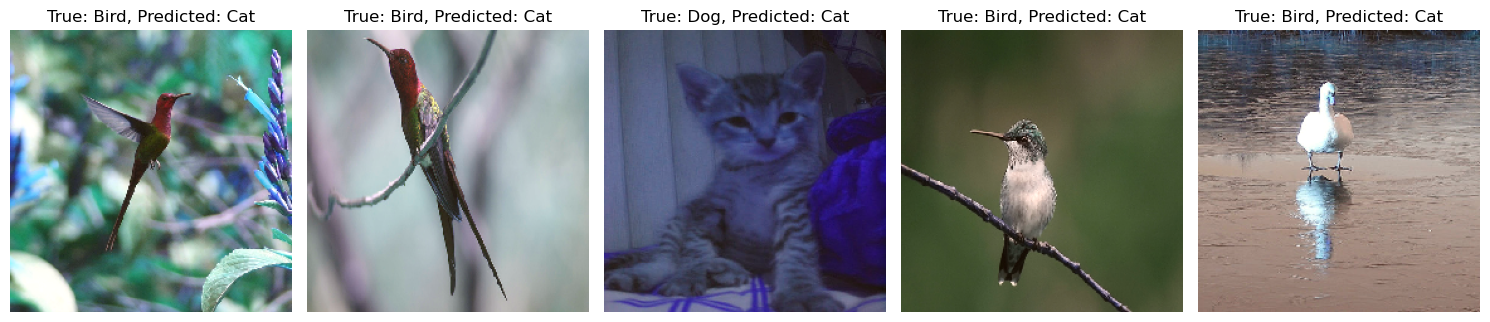

In [115]:
predictions = model.predict(X_test)

true_classes = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

incorrect_indices = np.where(predicted_classes != true_classes)[0]

class_names = ['Dog', 'Cat', 'Bird']

def plot_incorrect_images(incorrect_indices, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, index in enumerate(incorrect_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        print(X_test[index] * 255)
        plt.imshow((X_test[index] + 125) / 255) 
        plt.title(f'True: {class_names[true_classes[index]]}, Predicted: {class_names[predicted_classes[index]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_incorrect_images(incorrect_indices)


In [119]:
model.save('VGG-CatDogBird.keras')

### fine-tune the network

Fine-tune the entire network if you have enough computing ressouces, otherwise, carefully choose the layers you want to fine-tune.

In [113]:
for i, layer in enumeratUe(VGGmodel.layers):
   print(i, layer.name)
model.summary()

NameError: name 'enumeratUe' is not defined

In this example, we will fine-tune the last convolution block starting at layer number 15 (block5_conv).

In [ ]:
from keras.optimizers import RMSprop
for layer in model.layers[:15]:
   layer.trainable = False
for layer in model.layers[15:]:
   layer.trainable = True
#need to recompile the network
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
#and train again ...
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
 
model.fit(xTrain, yTrainCt, epochs=10, batch_size=16, validation_split=0.2, callbacks=[ourCallback],verbose=1)

In [ ]:
#enter here your code for evaluation of performances